#Full script for data analysis from sensor box

The signals were Gauss filterd.

For this selection, the min and max of light are 8.7e+02 and 3.1e+03 respectively.
For this selection, the min and max of noise-var are 4.6 and 1.5e+03 respectively.
For this selection, the min and max of noise-max are 2.1e+03 and 3.3e+03 respectively.
For this selection, the min and max of pir-percentage are 0.0 and 5.6e+01 respectively.


The signals were normalised.



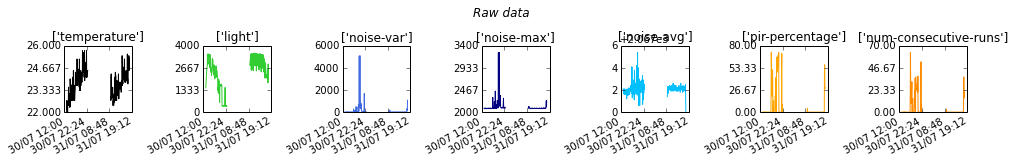

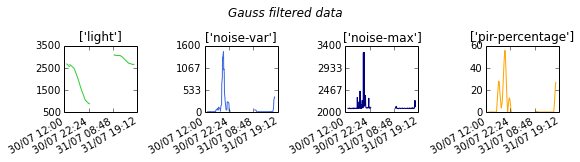

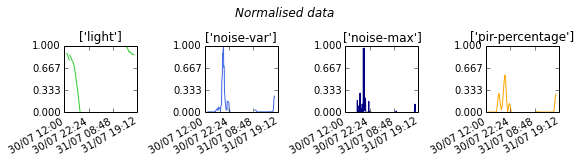

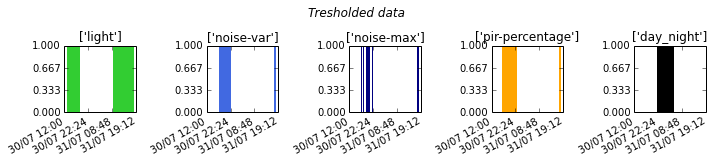

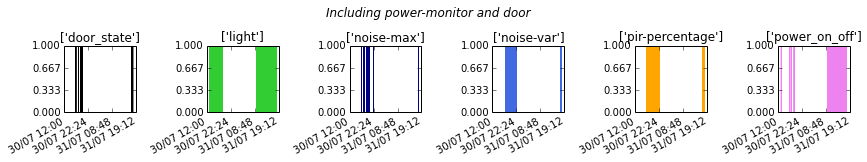

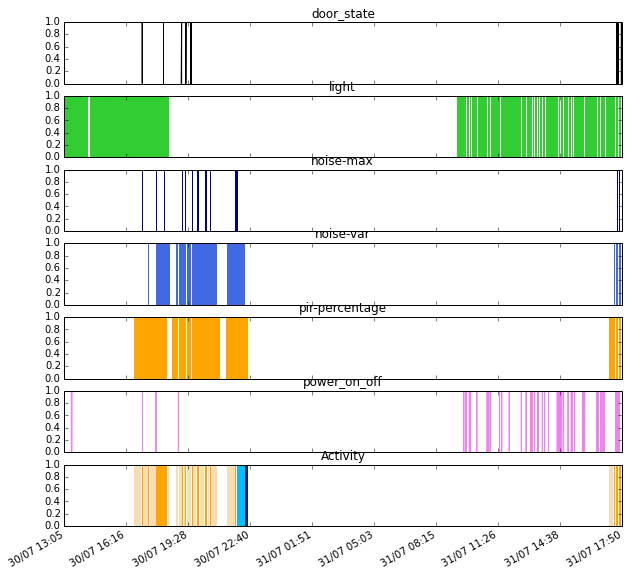

In [3]:
#LOADING PACKAGES
import numpy as np
import pandas as pd

#GUI
import Tkinter as tk

#load data from server and handle json and timestamps
import urllib2
import simplejson as json
from datetime import datetime

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import dates as mdates
from matplotlib.ticker import LinearLocator


###-----FUNCTIONS-----### 
class server_GUI(tk.Frame):
    def __init__(self, parent, date_format, *args, **kwargs):
        tk.Frame.__init__(self, parent, *args, **kwargs)
        self.grid()
        self.parent = parent
        self.date_format = date_format
        
        self.link = ""
        self.devices = ['53ff6d066667574831402467','54ff69066667515129441567']
        self.device = tk.StringVar(self.parent)
        
        self.initial_value = ['Hour','Day','07','2015']
        self.all_options = [['%02d'%(i) for i in range(0,24)],['%02d'%(i) for i in range(1,32)],['%02d'%(i) for i in range(1,13)],range(2015,2016)]
        
    def select_date(self):
        #DEVICE
        self.device.set('53ff6d066667574831402467')
        tk.Label(self.parent, text="Select device:").grid(row=0,column=0)
        apply(tk.OptionMenu, (self.parent, self.device) + tuple(self.devices)).grid(row=0,column=1)
        
        #START DATE
        tk.Label(self.parent, text="Select start date:").grid(row=1)
        self.var_start = [tk.StringVar(self.parent) for i in range(len(self.initial_value))]
        for i in range(len(self.initial_value)):
            self.var_start[i].set(self.initial_value[i])
            apply(tk.OptionMenu, (self.parent, self.var_start[i]) + tuple(self.all_options[i])).grid(row=2,column=i)
        
        #END DATE
        tk.Label(self.parent, text="Select end date:").grid(row=3)
        self.var_end = [tk.StringVar(self.parent) for i in range(len(self.initial_value))]
        for i in range(len(self.initial_value)):
            self.var_end[i].set(self.initial_value[i])
            apply(tk.OptionMenu, (self.parent, self.var_end[i]) + tuple(self.all_options[i])).grid(row=4,column=i)
        
        tk.Button(self.parent, text='OK', command=self.ok).grid(row=5,column=5)
        
    def ok(self):
        try:
            start = datetime(int(self.var_start[3].get()),int(self.var_start[2].get()),int(self.var_start[1].get()),int(self.var_start[0].get()))
            end =  datetime(int(self.var_end[3].get()),int(self.var_end[2].get()),int(self.var_end[1].get()),int(self.var_end[0].get()))
            print "The start date is {}, the end date {}, the device number is {}.".format(start.strftime(self.date_format),end.strftime(self.date_format),self.device.get())
            
            self.link = "http://109.237.25.161/particle/events?start_date={}&end_date={}&device={}".format(start.strftime(self.date_format),end.strftime(self.date_format),self.device.get())
            print "Created link: {}\n".format(self.link)
            
            self.parent.quit()
            
        except:
            print "Please try again!"

def load_data(device,parameters,api_link):
    dat = [[] for par in range(len(parameters))]
    timestamp = []
    
    for par in range(len(parameters)):
        link = api_link.format(device,parameters[par])
        decoded_json = json.loads(urllib2.urlopen(link).read())['measurements']
                
        for line in decoded_json:
            #if float(line["value"])!= 0.:
            dat[par].append(float(line["value"]))
            #else:
               # dat[par].append(np.nan)
    
    for line in decoded_json:
        timestamp.append(pd.Timestamp(line["timestamp"]))
        
    return pd.DataFrame(data=np.array(dat).T,index=timestamp,columns=parameters)

def add_devices(*data):
    result = pd.concat([frame for frame in data],axis=0,join='outer').sort_index()
    #result = pd.concat([frame for frame in data],axis=1,join='outer')
    
    for name in ["power1","power2","door"]:
        try:
            result[name]=result[name].ffill()
            for i in range(len(result[name].values)):
                if result[name].values[i]==0:
                    result[name].values[i] = np.nan
                else:
                    continue
        except KeyError:
            continue
            
    return result
        
def Gauss_filt(y, M, std):
    from scipy.signal import gaussian
    from scipy.ndimage import filters

    b = gaussian(M, std)
    ga = filters.convolve1d(y, b/b.sum())
    
    return ga

def filt_data(df,var,filt_params):
    filt_sig = np.zeros((len(df.index),len(var)))*np.nan
    
    for i in range(len(var)):
        ##find slices of df which are not NaN
        mask = np.ma.clump_unmasked(np.ma.masked_invalid(df[var[i]].values))
        ##Gauss filter these slices
        for s in range(len(mask)):
            filt_sig[mask[s],i] = Gauss_filt(df[var[i]].values[mask[s]],filt_params[var[i]][0],filt_params[var[i]][1])
    
    print "The signals were Gauss filterd.\n"
    return pd.DataFrame(filt_sig, index=df.index, columns=var)

def norm_data(df,min_max,cols):
    var = df.columns.values
    norm_sig = np.zeros(df.shape,dtype=float)*np.nan
    
    for i in range(len(var)):
        norm_sig[:,i] = (df[var[i]]-min_max[var[i]][0])/(min_max[var[i]][1]-min_max[var[i]][0])
        print "For this selection, the min and max of {0} are {1:.2} and {2:.2} respectively.".format(var[i], np.nanmin(df[var[i]].values), np.nanmax(df[var[i]].values))

    print "\n"
    print "The signals were normalised.\n"
    
    return pd.DataFrame(norm_sig, index=df.index, columns=var)

def treshold_data(df,treshold):
    lines = np.zeros(df.shape, dtype=int)*np.nan
    var = df.columns.values
        
    for i in range(len(var)):
        lines[:,i] = [1 if x>treshold[var[i]] else np.nan for x in df[var[i]]]
    
    return pd.DataFrame(lines, index=df.index, columns=var)

def infere(df,sunrise,sunset):
    levels = ["day_high","day_low","night_high","night_low"]
    activity = pd.DataFrame(np.zeros((len(df.index),4))*np.nan,index=df.index,columns=levels)
    
    for i in range(24):
        if sunrise <= i < sunset:
            for j, row in df[df.index.hour==i].iterrows():
                if np.nansum(row.values) >= 3:
                    activity["day_high"][activity.index==j] = 1
                elif np.nansum(row.values) == 2:
                    activity["day_low"][activity.index==j] = 1
                else:
                    continue
        else:
            for j, row in df[df.index.hour==i].iterrows():
                if np.nansum(row.values) > 1:
                    activity["night_high"][activity.index==j] = 1
                elif np.nansum(row.values) == 1:
                    activity["night_low"][activity.index==j] = 1
                else:
                    continue
            
    return activity

def plot_data(df,hfmt,cols,title="Plot",plt_type="line",**kwargs):
    var = df.columns.values
    
    fig, axs = plt.subplots(1,len(var), sharex=True, figsize=(2*len(var),2))
    fig.suptitle(title,y=1.1,fontsize=12,style='oblique')

    for i in range(len(var)):
        if plt_type=='line':
            axs[i].plot(df.index.to_datetime(),df[var[i]].values,color=cols[var[i]])
        elif plt_type=='fill':
            axs[i].fill_between(df.index.to_datetime(),0,df[var[i]].values,color=cols[var[i]])
        else:
            print "plt_type invalid!"
            break
        axs[i].set_title([var[i]],fontsize=12)
        axs[i].xaxis.set_major_formatter(hfmt)
        axs[i].xaxis.set_major_locator(LinearLocator(numticks=4))
        axs[i].yaxis.set_major_locator(LinearLocator(numticks=4))
        try:
            axs[i].set_ylim(kwargs['ylim'])
        except:
            pass
    
    fig.autofmt_xdate()
    fig.tight_layout()
    #fig.show()
    #fig.savefig(title,orientation="landscape")

def line_plot(df,df_act,hfmt,cols):
    var = df.columns.values
    levels = df_act.columns.values
    
    if "day_night" in var:
        n_plots = len(var)
    else:
        n_plots = len(var)+1
    
    fig, axs = plt.subplots(n_plots, 1, sharex=True, sharey=True, figsize=(10,10))

    for i in range(n_plots-1):
        if var[i] != "day_night":
            axs[i].fill_between(df.index.to_datetime(),0,df[var[i]].values,color=cols[var[i]])
            axs[i].set_title("{}".format(var[i]))
        else:
            continue
    
    lev_cols = ["orange","wheat","deepskyblue","midnightblue"]
    
    try:
        #plot night-time:
        axs[n_plots-1].fill_between(df.index.to_datetime(),0,df["day_night"].values,color="lightgray",alpha=.8)
    except KeyError:
        pass
   
    for j in range(len(levels)):
        axs[n_plots-1].fill_between(df_act.index.to_datetime(),0,df_act[levels[j]].values,color=lev_cols[j])
        axs[n_plots-1].set_title("Activity")

    axs[0].xaxis.set_major_locator(LinearLocator(numticks=10))
    axs[0].xaxis.set_major_formatter(hfmt)
    axs[0].set_ylim(0,1)
    
    fig.autofmt_xdate()
    
def random_data(n,duration,name):
    from datetime import timedelta
    
    on_off = np.array(n*[1,0], dtype=int)
    time_on = timedelta(minutes=duration)
    rd_date=[]
    
    #random date input
    ye = np.array([2015] * n)
    mo = np.array([7] * n)
    da = np.random.randint(29,31,n)
    ho = np.random.randint(0,24,n)
    mi = np.random.randint(0,60,n)
    
    for i in range(n):
        rd_date.append(datetime(ye[i],mo[i],da[i],ho[i],mi[i]))
        rd_date.append(datetime(ye[i],mo[i],da[i],ho[i],mi[i])+time_on)
    
    return pd.DataFrame(on_off, index=np.sort(rd_date), columns=name)

def add_day_night(df,sunrise,sunset):
    df["day_night"]=np.nan
    
    for i in range(24):
        if i >= sunset or i <= sunrise:
            df["day_night"][df.index.hour==i] = 1
        else:
            continue

def main():
    ###-----SETUP-----### 
    #format of input
    api_link = "http://109.237.25.161/particle/measurements?device={}&measurement={}"
    box_param = ["temperature","light","noise-var","noise-max","noise-avg","pir-percentage","num-consecutive-runs"]
    power_param = ["power_on_off","power_value"]
    door_param = ["door_state"]
    
    device = {"sb-stable":"53ff6d066667574831402467",
              "sb-testing":"54ff69066667515129441567",
              "door":"26002e001447343339383037",
              "power1":"43002f000a47343337373738",
              "power2":"210030000a47343337373738"
              }
        
    date_format = '%Y-%m-%d %H:%M:%S' #format of timestamp
    sunrise = 4 
    sunset = 22
    

    
    #parameters to be analysed
    para = [box_param[1],box_param[2],box_param[3],box_param[5]] #parameters used for analysis
    
    #input for gaussian filter ["number of points in output window","sigma"]
    filt_params = {
        "temperature":[1,1],
        "light":[100,60],
        "noise-max":[1,1],
        "noise-avg":[1,1],
        "noise-var":[10,15],
        "pir-percentage":[15,5],
        "num-consecutive-runs":[15,5]
    }
    
    #minimum and maximum for each paramater between 29/06 and 05/07 (EIETL data); used to normalise data
    min_max = {
            "temperature":[2.2e+01,2.6e+01],
            "light":[1.7e+03,2.8e+03],
            "noise-var":[4.8,1.5e+03],
            "noise-max":[2.1e+03,3.3e+03],
            "noise-avg":[2054.5,2087.8],
            "pir-percentage":[0.,100.],
            "num-consecutive-runs":[0.,2.6e+01]
    }

    #tresholds above which paramter is switched to 1 and below which it is set to NaN (empirical)
    tresholds = {
            "temperature":[.2],
            "light":[.1],
            "noise-max":[.05],
            "noise-avg":[.05],
            "noise-var":[.05],
            "pir-percentage":[.05],
            "num-consecutive-runs":[.05]
    }
    
    #plot setup
    hfmt = mdates.DateFormatter('%d/%m %H:%M') #display format of date
    cols = {
        "temperature":"black",
        "light":"limegreen",
        "noise-max":"navy",
        "noise-avg":"deepskyblue",
        "noise-var":"royalblue",
        "pir-percentage":"orange",
        "num-consecutive-runs":"darkorange",
        "power_on_off":"violet",
        "power_value":"green",
        "door_state":"black",
        "day_night":"black"
    }
    
    ###-----ANALYSIS-----### 
    
    #CALL GUI TO SELECT DATE
    #root = tk.Tk()
    #root.title('Select data to be fetched')

    #App = server_GUI(root,date_format)
    #App.select_date()

    #root.mainloop()
    #root.destroy()
    
    #LOAD DATA
    df = load_data(device["sb-stable"],box_param,api_link)
    power = load_data(device["power1"],power_param,api_link)
    door = load_data(device["door"],door_param,api_link)

    #device = App.device.get()
    
    #LOOK AT TIME INTERVALLS
    df = df.resample('5min', how='mean')
    
    #FILTER THE DATA (ONLY OF THE SUBSET "PARA" OF PARAMETERS)
    df_filt = filt_data(df,para,filt_params)
    
    #NORMALISE THE DATA 
    #normalise filtered data:
    df_norm = norm_data(df_filt,min_max,cols)
    
    #or normalise raw data(subset):
    #df_norm = norm_data(df[para],min_max,cols)
    
    #TRESHOLD THE NORMALISED DATA
    df_tresh = treshold_data(df_norm,tresholds)
    
    #MAKE RANDOM POWER MONITOR DATA
    #power = random_data(n=3,duration=1,name=['power_mon'])
    
    #MAP POWER DATA TO TRESHOLDED DATA
    df_all = add_devices(df_tresh,door,power[["power_on_off"]])
    
    #INFERENCE AND LINEPLOT
    df_activity = infere(df_all,sunrise,sunset)
    
    #ADD DAY AND NIGHT
    add_day_night(df_tresh,sunrise,sunset)
    
    #MAKE PLOTS
    plot_data(df,hfmt,cols,title="Raw data")
    plot_data(df_filt,hfmt,cols,title="Gauss filtered data")
    plot_data(df_norm,hfmt,cols,title="Normalised data",ylim=(0,1))
    plot_data(df_tresh,hfmt,cols,title="Tresholded data",plt_type="fill",ylim=(0,1))
    plot_data(df_all,hfmt,cols,title="Including power-monitor and door",plt_type="fill",ylim=(0,1))
    
    line_plot(df_all,df_activity,hfmt,cols)
    
# call main
if __name__ == '__main__':
    main()